**Este Colab Relaciono:**
* Matriz de Pearson -> Para Disminuir la cantidad de Numeros de variables que usar 
* Metodo del Codo -> Para Identificar el numero de clúster

In [1]:
import pandas as pd
#Cargue del Dataset y Elimino columnas que no me aportan al modelo 
Datos = pd.read_excel('mask_info_cli_ros_gmr.xlsx')
Datos.drop(['Unnamed: 0','nombre','num_caso','cod_ciiu','cod_ocup','cod_ciudad_dirp','cod_pais_nacim','pais_origen_recursos','pais_residencia','cod_categ_lc','riesgo_cliente__ric_','cod_subcateg_lc','cod_nivel_cat'], axis=1, inplace=True)
Datos.drop(['act_econom','desc_categ','motivo_ingreso_a_listas_de_control','ros'], axis=1, inplace=True)
print(Datos.shape)
display(Datos)

(25489, 31)


,doc,cod_tipo_doc,motivo_ros,tipologia,delito_fuente,segm_comercial,tipo_cli,sociedad_ccial_civ,ciiu,riesgo_actividad_economica,...,riesgo_pais_residencia,f_vinc,estado_cli,ctrl_terc,f_ingreso_lc,desc_subcateg,monto_total_anual_transado__efectivo_,frecuencia_total_anual_transada__efectivo_,monto_total_anual_transado__operaciones_internacionales_,frecuencia_total_anual_transada__operaciones_internacionales_
0,1795648757079224064,-7857548262053045248,Posible Operacion LA,Posible Operacion LA,Delitos contra el sistema financiero,PERSONAL,PERSONA NATURAL,NaN,ASALARIADOS,BAJO,...,MEDIO,19990305.0,ACTIVO,CLIENTE,NaN,NaN,0.0,0,0.000000e+00,0.0
1,1795648757079224064,-7857548262053045248,Posible Operacion LA,Posible Operacion LA,Delitos contra el sistema financiero,PERSONAL,PERSONA NATURAL,NaN,ASALARIADOS,BAJO,...,MEDIO,19990305.0,ACTIVO,CLIENTE,NaN,NaN,0.0,0,0.000000e+00,0.0
2,-6985489109544592384,-7857548262053045248,Operaciones intentadas,Captacion ilegal de recursos,Posible Operacion LA,PERSONAL,PERSONA NATURAL,NaN,ASALARIADOS,BAJO,...,MEDIO,20010725.0,INACTIVO,EXCLIENTE,20120125.0,MEDIOS DE COMUNICACION ...,0.0,0,0.000000e+00,0.0
3,-1763763190338963968,-7857548262053045248,Posible Operacion LA,Fraccionamiento de operaciones o Pitufeo,Posible Operacion LA,PERSONAL,PERSONA NATURAL,NaN,NaN,NaN,...,MEDIO,20220503.0,INACTIVO,EXCLIENTE,NaN,NaN,0.0,0,0.000000e+00,0.0
4,8796937099972244480,277454362497989792,Posible Operacion LA,Posible Operacion LA,Enriquecimiento ilicito de particulares,PLUS,PERSONA NATURAL,NaN,NaN,NaN,...,MEDIO,20130903.0,ACTIVO,CLIENTE,NaN,NaN,0.0,0,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,2935992378822940160,-1161566326870921984,Posible Operacion LA,Posible Operacion LA,DELITOS CONTRA EL SISTEMA FINANCIERO,INDEPENDIENTES,PERSONA NATURAL,NaN,ASALARIADOS,BAJO,...,MEDIO,20190108.0,ACTIVO,CLIENTE,NaN,NaN,0.0,0,0.000000e+00,0.0
25485,-4444238732361294848,-1161566326870921984,Posible Operacion LA,Posible Operacion LA,DELITOS CONTRA EL SISTEMA FINANCIERO,INDEPENDIENTES,PERSONA NATURAL,NaN,NaN,NaN,...,MEDIO,20190409.0,ACTIVO,CLIENTE,NaN,NaN,40920000.0,63,2.361093e+08,238.0
25486,-7627565057185927168,-1161566326870921984,Posible Operacion LA,Posible Operacion LA,DELITOS CONTRA EL SISTEMA FINANCIERO,INDEPENDIENTES,PERSONA NATURAL,NaN,"COMERCIO AL POR MENOR DE ALIMENTOS, BEBIDAS Y ...",MEDIO,...,MEDIO,20231025.0,ACTIVO,CLIENTE,NaN,NaN,40920000.0,63,2.361093e+08,238.0
25487,-3404692965361613824,-1161566326870921984,Posible Operacion LA,Posible Operacion LA,DELITOS CONTRA EL SISTEMA FINANCIERO,INDEPENDIENTES,PERSONA NATURAL,NaN,OTRAS ACTIVIDADES DE SERVICIO DE APOYO A LAS E...,BAJO,...,MEDIO,20231102.0,ACTIVO,CLIENTE,NaN,NaN,93387032.0,36,9.332137e+06,27.0


Se Identifico un Registro mal Ingresado tenia el texto (CAPTURADO POR NARCOTRÁFICO CASO 1086954                                                                        ") se le puso el mismo valor que tenia la columna frecuencia_total_anual_transada__efectivo_

In [2]:
Datos['monto_total_anual_transado__efectivo_'] = Datos['monto_total_anual_transado__efectivo_'].replace({'CAPTURADO POR NARCOTRÁFICO CASO 1086954                                                                        "': 42940000})
Datos["monto_total_anual_transado__efectivo_"] = pd.to_numeric(Datos["monto_total_anual_transado__efectivo_"], errors='coerce')

In [3]:
#Identifico variables categoricas y las Numericas
num_cols = Datos.select_dtypes(exclude=['object']).columns
cat_cols = Datos.select_dtypes(include=['object']).columns

In [4]:
from sklearn.impute import SimpleImputer
#Imputo Columnas Numericas
imputer = SimpleImputer(strategy='constant', fill_value=0)
NumImp = pd.DataFrame(imputer.fit_transform(Datos[num_cols]), columns=Datos[num_cols].columns)

In [5]:
#Imputo Columnas Categoricas
imputer = SimpleImputer(strategy='constant', fill_value='Sin Informacion')
CatImp = pd.DataFrame(imputer.fit_transform(Datos[cat_cols]), columns=Datos[cat_cols].columns)

In [6]:
#Concateno el Dataframe con columnas ya Imputadas
Datos = pd.concat([CatImp, NumImp], axis=1)

In [7]:
#Para Disminuir la Dimencion de los valores Dividi en rangos estas 6 Columnas
columnas = ['ing_mes','egresos_mes','monto_total_anual_transado__efectivo_','monto_total_anual_transado__operaciones_internacionales_','frecuencia_total_anual_transada__operaciones_internacionales_','frecuencia_total_anual_transada__efectivo_']
Convertir = Datos[columnas]

In [8]:
#Funcion para convertir en Rangos 
def asignar_rangos(df, columnas):
    def dividir_en_rangos(col):
        valores_unicos = sorted(col.dropna().unique()) # Obtener valores únicos y ordenarlos
        total_valores = len(valores_unicos)
        if total_valores < 10:
            return col.apply(lambda x: "Rango menor de 10" if pd.notna(x) else x)
        block_size = total_valores // 10 # Defini el tamaño de cada bloque
        remainder = total_valores % 10
        rangos = []
        start = 0
        for i in range(10):
            end = start + block_size + (1 if i < remainder else 0)
            if end > total_valores:
                end = total_valores
            min_val = valores_unicos[start]
            max_val = valores_unicos[end - 1]
            rangos.append((min_val, max_val))
            start = end
        def asignar_rango(valor):
            if pd.isna(valor):
                return valor
            for min_val, max_val in rangos:
                if min_val <= valor <= max_val:
                    return f"Rango entre {min_val} y {max_val}"
        return col.apply(asignar_rango)
    for columna in columnas:
        if columna in df.columns:
            df.loc[:, columna] = dividir_en_rangos(df[columna]) 
    return df
Rangos = asignar_rangos(Convertir.copy(), columnas) 

In [9]:
#Elimine las columnas indicadas y adicione las nuevas ya con los rangos
Datos.drop(columns=columnas, inplace=True)
Datos = pd.concat([Datos, Rangos], axis=1)

In [10]:
#Aplico LabelEncpder para las columnas categoricas 
from sklearn.preprocessing import LabelEncoder
Categoricas = Datos.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in Categoricas:
    Datos[col] = le.fit_transform(Datos[col])

In [11]:
# Normalizamos con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DatoS = scaler.fit_transform(Datos)
DatoScal = pd.DataFrame(DatoS, columns=Datos.columns)

**Matriz de Pearson**

Para Identificar que columnas mas cercanas a Cero ya que no aportan positiva ni negativamente

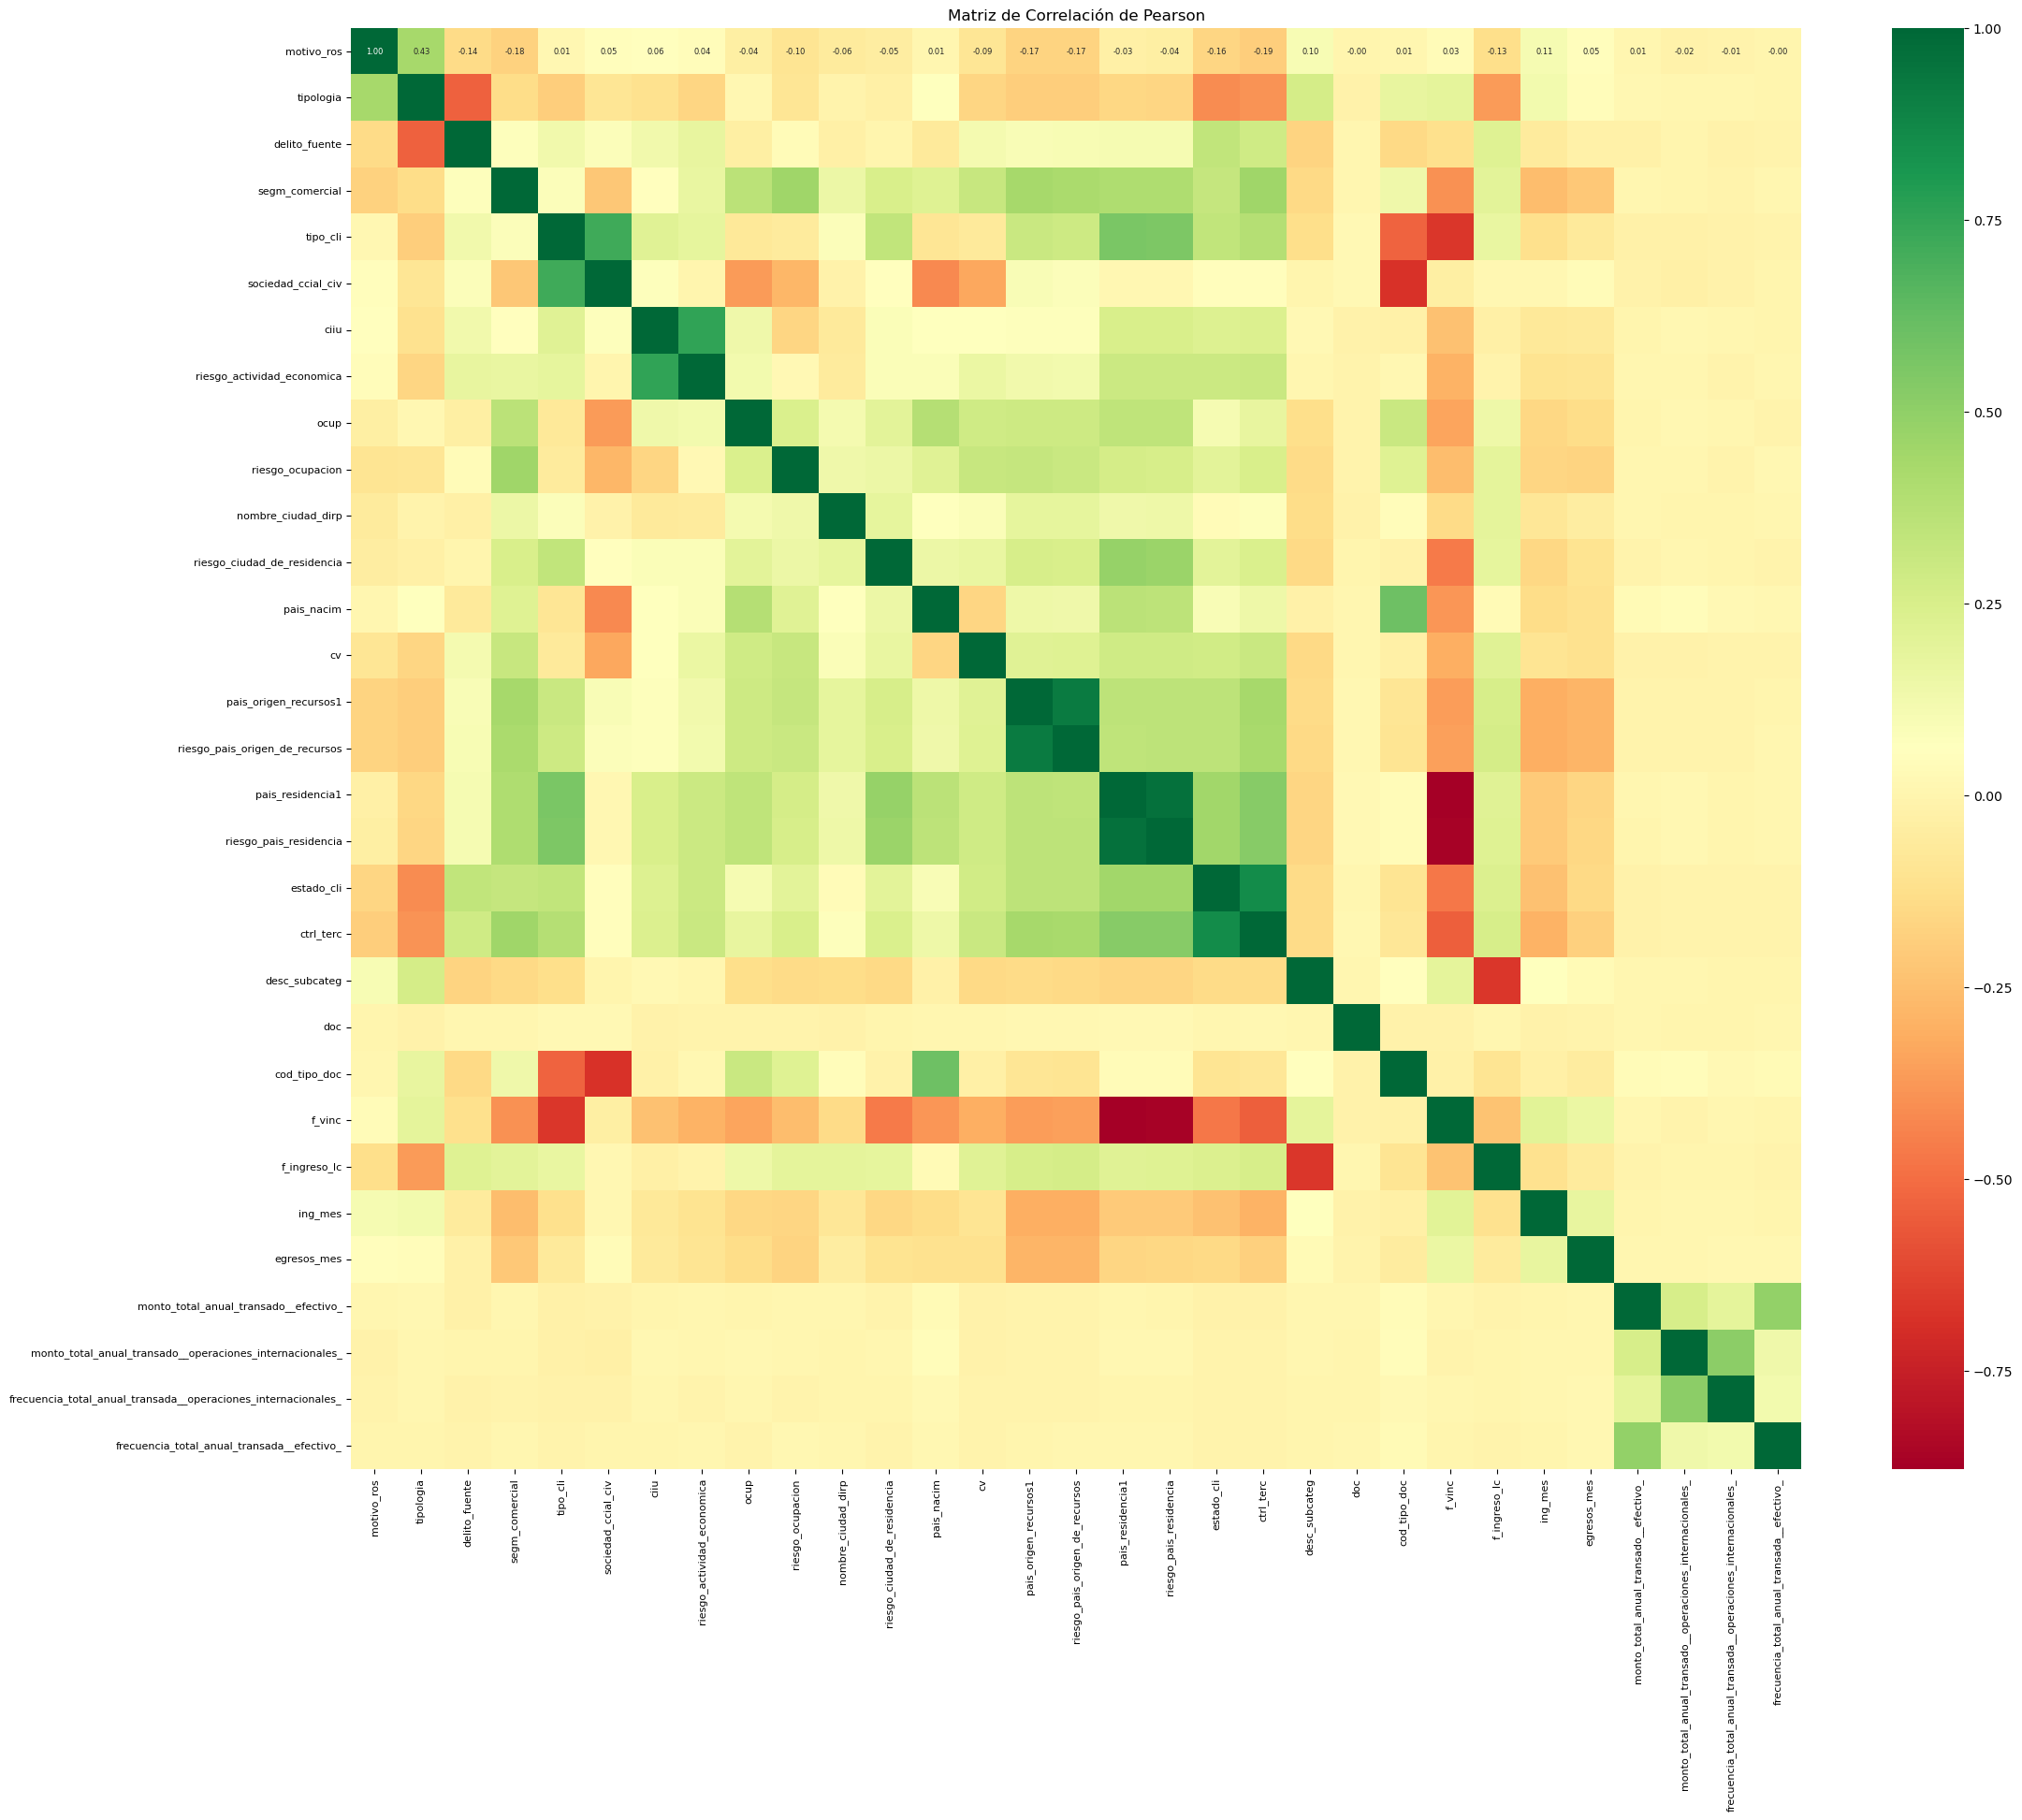

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
#La matriz de correlación de Pearson asume una relación lineal entre las variables
Pearson = DatoScal.corr(method='pearson')
fig, ax = plt.subplots(figsize=(25, 20))
# Matriz de correlación Pearson
sns.heatmap(Pearson, annot=True, cmap='RdYlGn', fmt=".2f", annot_kws={"size": 6}, ax=ax)
ax.set_title('Matriz de Correlación de Pearson', fontsize=12)
ax.tick_params(labelsize=8)
plt.show()

In [13]:
#Relacion de columnas que posiblemente pueda eliminar
numerical_columns = Datos.select_dtypes(include=['float64', 'int64']).columns
Pearson_corr = Datos[numerical_columns].corr(method='pearson')# Calcular la matriz de correlación de Pearson
threshold = 0.5  # Se Utiliza este Umbral para considerar la correlación como insignificante
variablePosibleEliminacion = [] # Lista para almacenar las columnas a eliminar
for column in numerical_columns:# Iterar sobre las columnas numéricas
    # Excluir la correlación con la misma variable (diagonal)
    correlation_values = Pearson_corr[column].drop(column)
    # Verificar si todas las correlaciones están por debajo del umbral
    if all(abs(correlation_values) < threshold):
        variablePosibleEliminacion.append(column)
print("Columnas a eliminar:", variablePosibleEliminacion)

Columnas a eliminar: ['doc', 'cod_tipo_doc', 'f_vinc', 'f_ingreso_lc']


In [14]:
#De las 4 variables que menciona solo dejo el 'doc' ya que es muy importante para relacionar cuando entrege el datos Final
#variablePosibleEliminacion = ['doc', 'cod_tipo_doc', 'f_vinc', 'f_ingreso_lc']
variablePosibleEliminacion.remove('doc')

In [15]:
Datos = Datos.drop(columns=variablePosibleEliminacion)

# **Metodo del Codo**
Para identificar el número óptimo de clusters

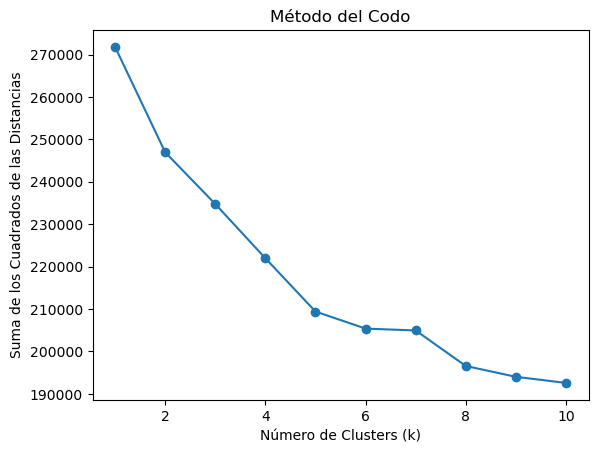

In [16]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
ssd = []
k_range = range(1, 11)
for k in k_range:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit(Datos)
    ssd.append(km.cost_)
plt.plot(k_range, ssd, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Suma de los Cuadrados de las Distancias')
plt.title('Método del Codo')
plt.show()

# **Método silhouette**

Método silhouette para identificar el número óptimo de clusters

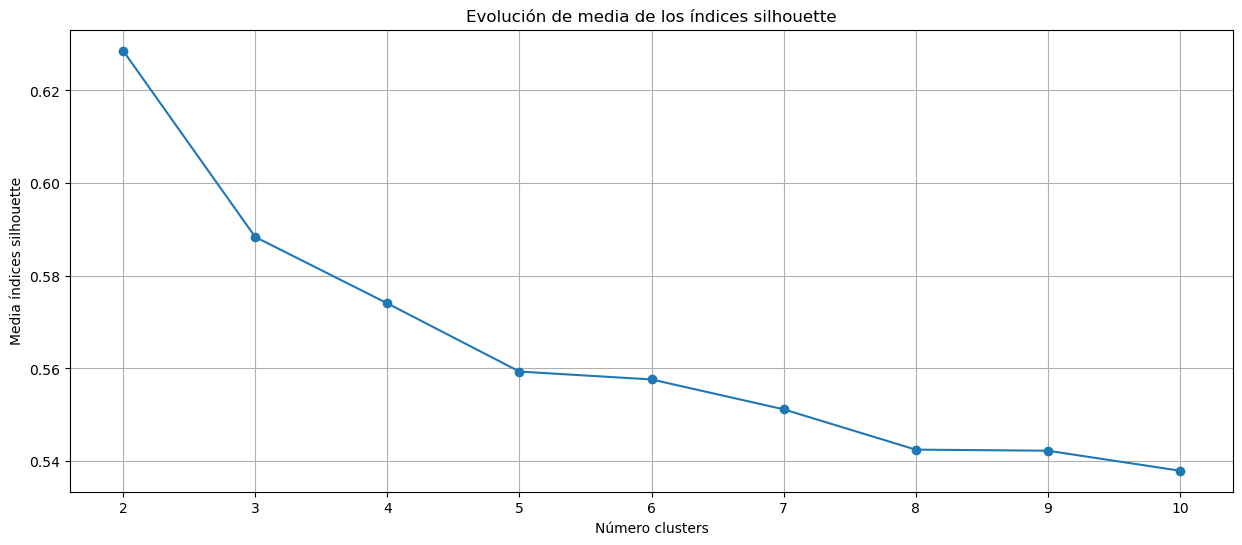

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
valores_medios_silhouette = []
range_n_clusters = range(2, 11)  # Comienza en 2 porque silhouette no está definido para un solo cluster

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=10
    )
    cluster_labels = modelo_kmeans.fit_predict(Datos)
    silhouette_avg = silhouette_score(Datos, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
ax.grid(True)
plt.show()

# **Distancia Intra-cluster (Inertia) o Suma de Errores Cuadráticos (SSE)**

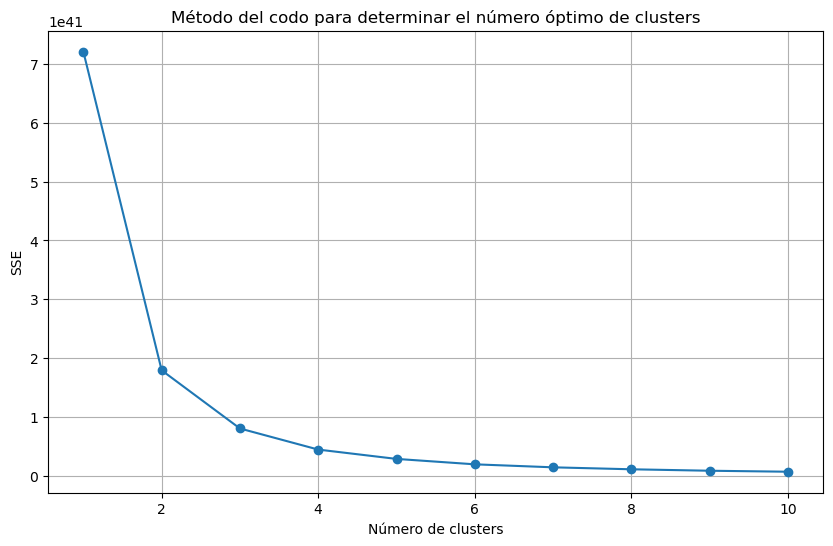

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    kmeans.fit(Datos)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.grid(True)
plt.show()